In [1]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 

from typing import Any, Optional, List

import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.strategy import IStrategy, StrategyContext, TriggerEvent, PositionsTracker
from qubx.pandaz.utils import *
import qubx.pandaz.ta as pta

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.trackers import PortfolioRebalancerTracker
from qubx.ta.indicators import sma, ema
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC, AsPandasFrame, RestoreTicksFromOHLC, AsOhlcvSeries
from qubx.core.basics import Deal, Instrument, Order, Position, Signal

from qubx import QubxLogConfig
from qubx.backtester.simulator import simulate
from qubx.core.metrics import tearsheet
from qubx.trackers.sizers import FixedSizer, FixedRiskSizer
from qubx.core.metrics import chart_signals

 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


# Strat for signals testing

In [36]:
class StrategyForTracking(IStrategy):
    timeframe: str = "1Min"
    fast_period = 5
    slow_period = 12

    def on_fit(self, ctx: StrategyContext, fit_time: str | pd.Timestamp, previous_fit_time: str | pd.Timestamp | None = None):
        logger.info(f" -> Fit is called | fit_time: {fit_time} / prev: {previous_fit_time}")

    def on_event(self, ctx: StrategyContext, event: TriggerEvent) -> List[Signal] | None:
        signals = []
        for i in ctx.instruments:
            ohlc = ctx.ohlc(i, self.timeframe)
            fast = sma(ohlc.close, self.fast_period)
            slow = sma(ohlc.close, self.slow_period)
            pos = ctx.positions[i.symbol].quantity

            if pos <= 0 and (fast[0] > slow[0]) and (fast[1] < slow[1]):
                signals.append(i.signal(+1, stop=ohlc[1].low))

            if pos >= 0 and (fast[0] < slow[0]) and (fast[1] > slow[1]):
                signals.append(i.signal(-1, stop=ohlc[1].high))

        return signals

    def tracker(self, ctx: StrategyContext) -> PositionsTracker:
        return PositionsTracker(FixedRiskSizer(1, 10_000, reinvest_profit=True))

In [37]:
from qubx.trackers.riskctrl import AtrRiskTracker

r = CsvStorageDataReader("../tests/data/csv")

QubxLogConfig.set_log_level("ERROR")

rep = simulate({
        "As Strategy 1": [
            StrategyForTracking(timeframe="15Min", fast_period=5, slow_period=25),
        ],

        "As Strategy 2": [
            StrategyForTracking(timeframe="15Min", fast_period=5, slow_period=25),
            AtrRiskTracker(10, 5, '15Min', 50, atr_smoother='kama', sizer=FixedRiskSizer(0.5))
        ]
    },
    r, 10000, [ "BINANCE.UM:BTCUSDT" ], 
    dict(type="ohlc", timeframe="15Min", nback=0),
    "-1Sec",
    "vip0_usdt", 
    "2024-01-01", "2024-01-20", 
)

  0%|          | 0/2 [00:00<?, ?it/s]

Simulating:   0%|          | 0/1641600.0 [00:00<?, ?s/s]

Simulating:   0%|          | 0/1641600.0 [00:00<?, ?s/s]

,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
/As Strategy 1,-940.658452,-0.835179,-3.438072,-2.604379,18.722485,2053.190573,-5.071091,-6.388832,0.846201,0.842409,457.034262,-0.461240,1025.147202,105.0
/As Strategy 2,-223.542273,-0.338069,-4.074867,-2.470581,3.676542,371.268730,-5.731568,-10.955637,0.792131,0.866750,95.104250,-0.111669,183.479223,110.0


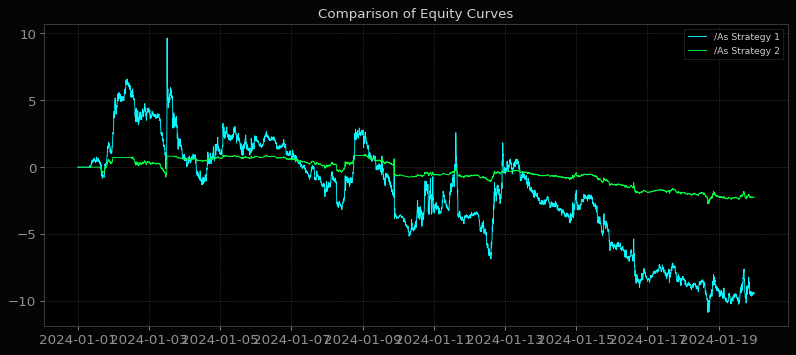

In [38]:
tearsheet(rep)

In [42]:
rep[0].executions_log

,instrument_id,side,filled_qty,price,commissions,commissions_quoted
timestamp,,,,,,
2024-01-01 07:44:59.999,BTCUSDT,buy,0.235,42475.45,4.990865,USDT
2024-01-01 14:59:59.999,BTCUSDT,sell,-0.469,42645.55,10.000381,USDT
2024-01-01 15:44:59.999,BTCUSDT,buy,0.467,42885.65,10.013799,USDT
2024-01-02 11:59:59.999,BTCUSDT,sell,-0.452,45486.75,10.280006,USDT
2024-01-02 14:14:59.999,BTCUSDT,buy,0.437,45815.35,10.010654,USDT
...,...,...,...,...,...,...
2024-01-18 23:44:59.999,BTCUSDT,buy,0.449,41308.15,9.273680,USDT
2024-01-19 02:59:59.999,BTCUSDT,sell,-0.485,41112.35,9.969745,USDT
2024-01-19 05:59:59.999,BTCUSDT,buy,0.485,41207.15,9.992734,USDT


# Atr Tracker + generated signals

In [112]:
from qubx.trackers.riskctrl import AtrRiskTracker
QubxLogConfig.set_log_level("DEBUG")


r = MultiQdbConnector('xlydian-data')
rep = simulate(
    {
        "test0": [pd.Series(
            {
                "2024-01-01 10:00": 1,
                # "2024-01-02 12:00": 0,
                "2024-01-02 12:00": 1,
                "2024-01-03 10:00": -1,
                "2024-01-04 15:00": 0,

                "2024-01-04 16:00": 1,
                "2024-01-04 16:10": 2,
                "2024-01-05 17:00": 0,
            }, name='BTCUSDT'), 
                  AtrRiskTracker(5, 5, '5Min', 32, sizer=FixedRiskSizer(0.5))
            ],
    },

    r, 10000, ["BINANCE.UM:BTCUSDT"], 
    dict(type="ohlc", timeframe="1Min", nback=30), "-1Sec", "vip0_usdt", "2024-01-01", "2024-01-05", 
)

2024-08-02 08:08:23.078 [ 🐞 ] Connected to QuestDB at xlydian-data:8812
2024-08-02 08:08:23.078 [ 🐞 ] 2024-01-01 00:00:00 Initiating simulated trading for binance.um for 10000 x 1.0 in USDT...
2024-01-01 00:00:00.000 [ ℹ️ ] SimulatedData.binance.um initialized


Simulating:   0%|          | 0/406800.0 [00:00<?, ?s/s]

2024-01-01 00:00:00.000 [ 🐞 ] Using pre-generated signals:
 7
2024-01-01 00:00:00.000 [ 🐞 ] Triggering strategy on every 1Min bar after 
2024-01-01 00:00:00.000 [ ℹ️ ] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1Min', 'nback': 30} for 
	['BTCUSDT'] 
2024-01-01 00:00:00.000 [ 🐞 ] SimulatedExchangeService :: subscribe :: BTCUSDT :: ohlc
2024-01-01 00:00:00.000 [ ℹ️ ] SimulatedExchangeService :: run :: Simulation started at 2024-01-01
2024-01-01 00:00:00.000 [ ℹ️ ] Initializing chunks for each loader
2023-12-31 23:30:00.001 [ 🐞 ] [2023-12-31T23:30:00.001000000]: Invoking _GeneratedSignalsStrategy on_fit('2024-01-01 00:00:00', 'None')
2023-12-31 23:30:00.001 [ 🐞 ] [2023-12-31T23:30:00.001000000]: _GeneratedSignalsStrategy is fitted
2024-01-01 10:00:00.001 [ 🐞 ] 	 ::: Start tracking Target for  +1.000000 BTCUSDT stop: 42478.318750000006 take: 42899.381250000006 on BINANCE.UM [] -> 0.23749443372421056 of BTCUSDT take: 42899.381250000006 stop: 42478.318750000006
2024-0

2024-01-04 20:38:36.000 [ 🐞 ] BTCUSDT >>> Adjusting position from 0.07 to 0 : [SIM-ORDER-BTCUSDT-100009] MARKET SELL 0.07 of BTCUSDT  (gtc) [CLOSED]
2024-01-05 17:00:00.001 [ 🐞 ] 	 ::: Start tracking Target for  +0.000000 BTCUSDT on BINANCE.UM -> 0 of BTCUSDT take: None stop: None
2024-01-05 17:00:00.001 [ ⚠️ ] qubx.gathering.simplest:alter_position_size:17 - Can't change position size for BINANCE.UM:BTCUSDT [CRYPTO PERPETUAL (1.0) 2019-09-25T11:00:00 -> 2100-12-25T10:00:00]. Current position: 0.0, requested size: 0
2024-01-05 17:00:59.999 [ ℹ️ ] SimulatedExchangeService :: run :: Simulation finished at 2024-01-05 17:00:00


In [ ]:
tearsheet(rep, False)

In [108]:
rep[0].executions_log

,instrument_id,side,filled_qty,price,commissions,commissions_quoted
timestamp,,,,,,
2024-01-01 10:00:00.001,BTCUSDT,buy,0.237,42688.85,5.058629,USDT
2024-01-01 18:01:36.000,BTCUSDT,sell,-0.237,42908.35,5.084639,USDT
2024-01-02 12:00:00.001,BTCUSDT,buy,0.100,45486.85,2.274343,USDT
2024-01-02 15:17:36.000,BTCUSDT,sell,-0.100,44932.95,2.246647,USDT
2024-01-03 10:00:00.001,BTCUSDT,sell,-0.115,45378.55,2.609267,USDT
2024-01-03 11:08:36.000,BTCUSDT,buy,0.115,44928.55,2.583392,USDT
2024-01-04 16:00:00.001,BTCUSDT,buy,0.072,44050.45,1.585816,USDT
2024-01-04 16:10:00.001,BTCUSDT,sell,-0.002,43899.65,0.043900,USDT
2024-01-04 20:38:36.000,BTCUSDT,sell,-0.070,44840.75,1.569426,USDT


In [93]:
ohlc_pd1 = r.read('BINANCE.UM:BTCUSDT', '2024-01-01', '2024-02-05', AsPandasFrame())
ohlc_pd = ohlc_resample(ohlc_pd1, '5Min')

In [109]:
chart_signals(rep[0], "BTCUSDT", ohlc_pd1, overlay=[
    ohlc_pd.close - 5*pta.atr(ohlc_pd, 32),
    ohlc_pd.close + 5*pta.atr(ohlc_pd, 32),
], info=0)

(None, None)